In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from pixell import curvedsky
from pixell import powspec
import numpy as np
import matplotlib.pyplot as plt

We first load the scalar Cls from a CAMB run.

In [3]:
fname = "data/new_ethos_a4_scalCls.dat"
CMB, lensing = powspec.read_camb_scalar(fname)

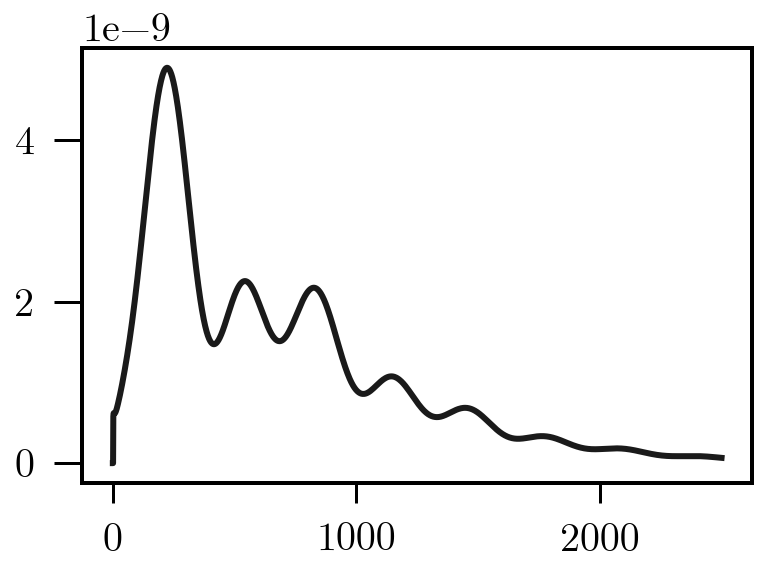

In [4]:
plt.plot(np.arange(2500)**2 * CMB[0,0,:2500])

Next, initialize a WCS object with the CAR (plate caree) system, with pixel size 0.05 radian centered at the `pos` input, also in radians for RA/DEC. We then use the TT spectrum we loaded from CAMB and generate a realization with `rand_map`.

You should reduce the resolution (in `shape`) if you run this on a lesser machine! 1000x1000 takes my 16 core workstation about 5 minutes in total to run this notebook.

In [5]:
shape=(1,1000,1000)
rdeg = np.pi/180
wcs = curvedsky.wcsutils.build( pos=[(-0.1,0.1),(0.1,0.2)], res=0.05, system="CAR")
test_map = curvedsky.rand_map(shape,  wcs, CMB[0,0,:], lmax=2000)

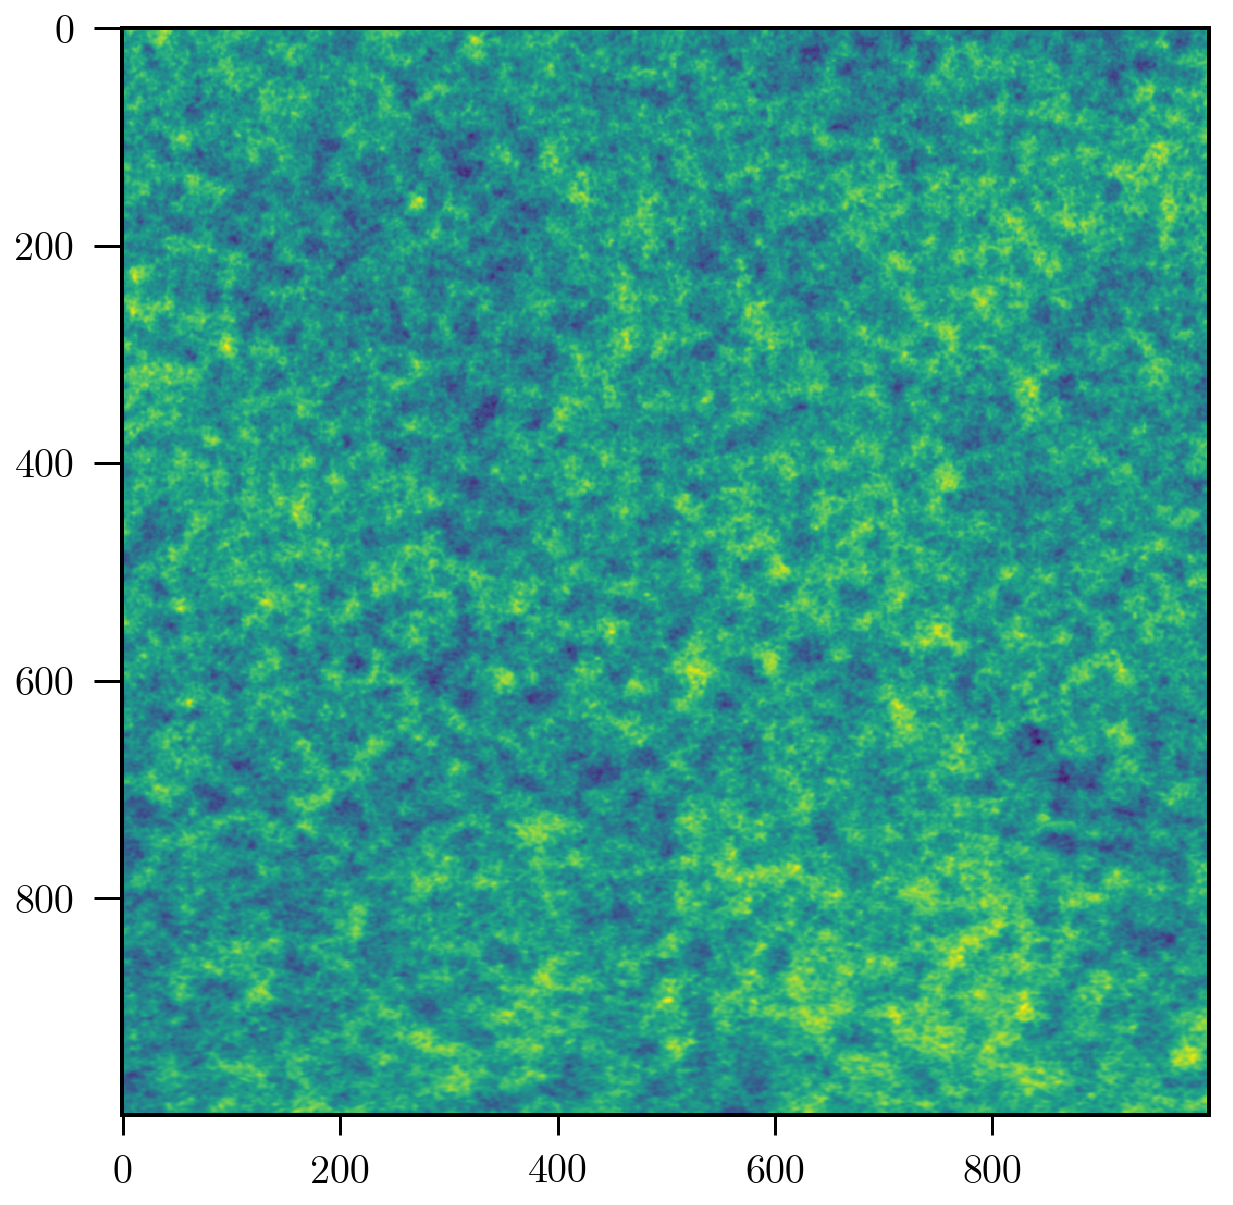

In [6]:
plt.figure(figsize=(10,10))
plt.imshow( test_map[0,:,:] )

In [7]:
from pixell import enmap

In [8]:
heal_map = enmap.to_healpix(test_map[0,:,:])

In [9]:
heal_map.shape

(12582912,)

In [10]:
NSIDE = int(np.sqrt(heal_map.shape[0] / 12))

In [11]:
import healpy as hp
import matplotlib.pyplot as plt

#Import the NaMaster python wrapper|
import pymaster as nmt

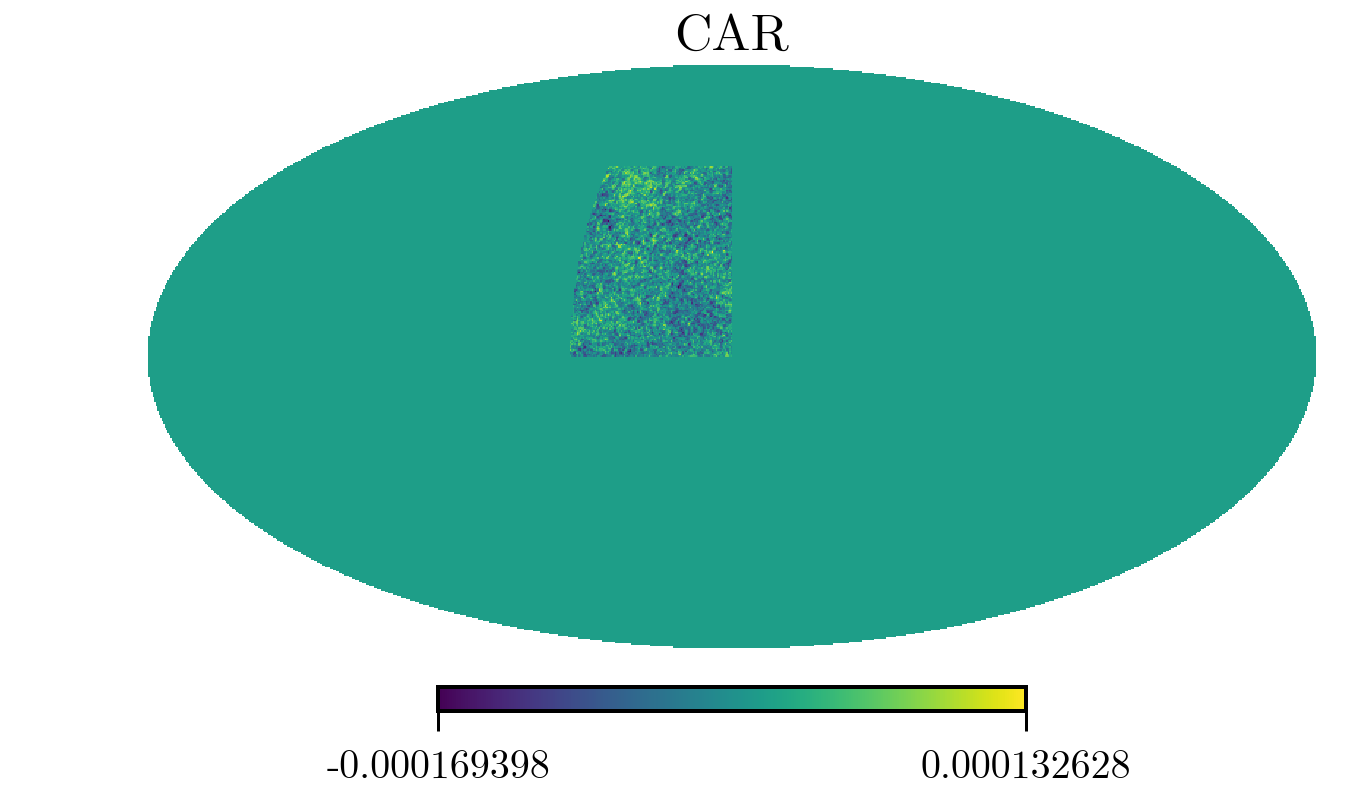

In [12]:
hp.mollview(heal_map,  title="CAR")
# hp.write_map("test_heal.fits", heal_map, overwrite=True)

We make a simple mask using the map we just generated.

In [13]:
mask=nmt.mask_apodization( heal_map != 0.0,1.,apotype="Smooth")
# hp.write_map("test_mask.fits", mask, overwrite=True)

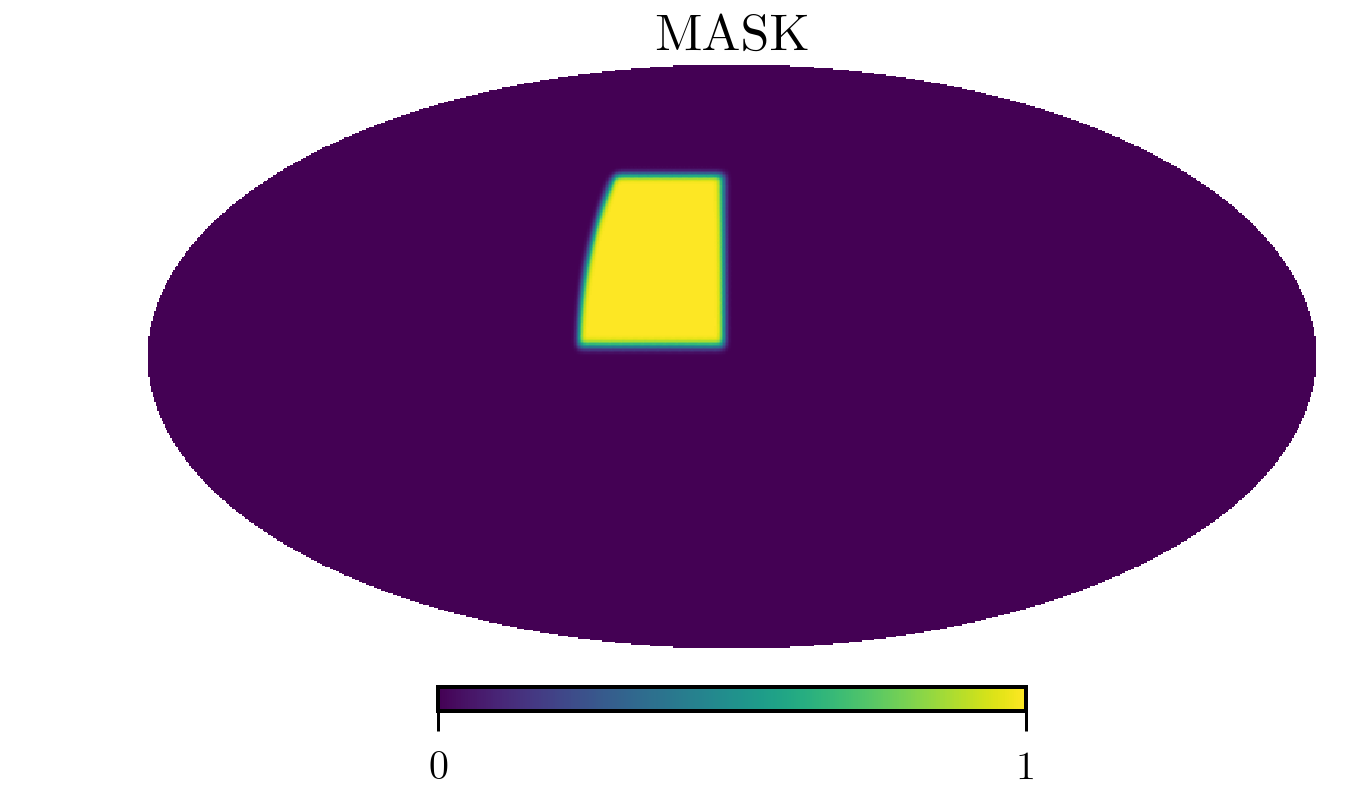

In [14]:
hp.mollview(mask,  title="MASK")

Now we compute the power spectrum using pseudo-$C_{\ell}$ from this mask and map! We make a NaMaster field object, set up some bins, compute, and then plot.

In [15]:
f_0 = nmt.NmtField(mask,[heal_map])

In [16]:
b=nmt.NmtBin(NSIDE,nlb=40) # bins of width 40 in ell

In [17]:
cl_00=nmt.compute_full_master(f_0,f_0,b)

(0, 2000)

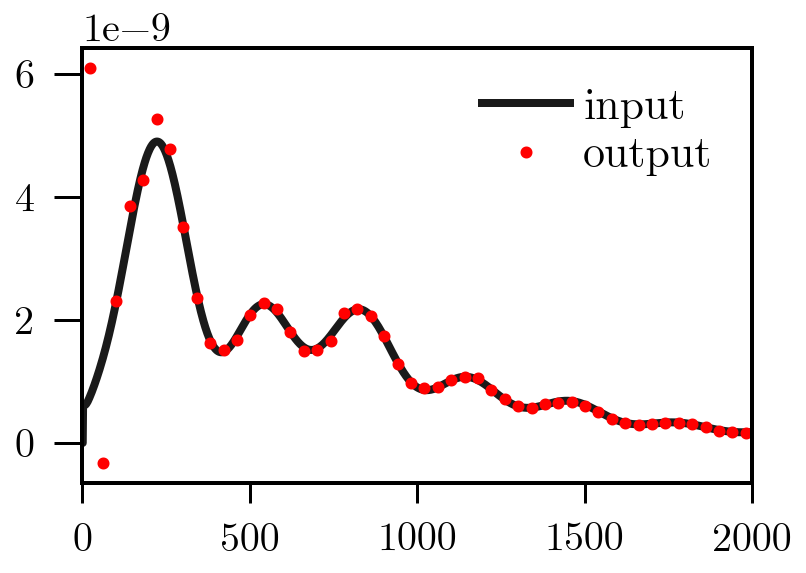

In [18]:
ell_arr=b.get_effective_ells()
plt.plot( np.arange(2000)**2 * CMB[0,0,:2000], label="input", lw=4)
plt.plot(ell_arr,ell_arr**2 * cl_00[0],'ro',label="output")
plt.legend()
plt.xlim(0,2000)